In [10]:
import gym
from gym import spaces
import numpy as np

class EnergyTransmissionEnv(gym.Env):
    def __init__(self):
        super(EnergyTransmissionEnv, self).__init__()
        
        self.max_energy = 1000
        self.action_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=self.max_energy, shape=(5,), dtype=np.float32)

    def reset(self):
        self.solar = np.random.uniform(100, 300)
        self.wind = np.random.uniform(100, 300)
        self.hydro = np.random.uniform(100, 300)
        self.thermal = np.random.uniform(100, 300)
        self.demand = np.random.uniform(400, 900)

        self.state = np.array([self.solar, self.wind, self.hydro, self.thermal, self.demand])
        return self.state


    def step(self, action):
        action_sum = np.sum(action)
        if action_sum == 0 or np.isnan(action_sum):
            action = np.ones(4) / 4  # fallback to equal distribution
        else:
            action = action / action_sum  # Normalize

        sources = np.array([self.solar, self.wind, self.hydro, self.thermal])
        total_available = np.sum(sources)
        demand = self.demand

        source_weights = sources / total_available
        equal_dist = np.array([0.25, 0.25, 0.25, 0.25])
        alpha = 0.7
        guided_weights = alpha * source_weights + (1 - alpha) * equal_dist

        penalty_for_deviation = np.sum(np.square(action - guided_weights)) * 10

        transmitted = sources * action
        supplied = np.sum(transmitted)

        loss = 0.05 * supplied
        congestion_penalty = max(0, supplied - demand - 50) * 3
        cost_per_source = [2, 3, 1.5, 4]
        cost = np.dot(action, cost_per_source)

        reward = - (loss + cost + congestion_penalty + penalty_for_deviation)
        done = True
        if np.any(np.isnan(action)) or np.any(np.isnan(self.state)):
            print("NaN detected!", action, self.state)


        return self.state, reward, done, {}



 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.16.45.3:5000
Press CTRL+C to quit
127.0.0.1 - - [05/Apr/2025 23:16:31] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [05/Apr/2025 23:16:32] "GET /favicon.ico HTTP/1.1" 404 -


In [8]:
from stable_baselines3 import PPO

env = EnergyTransmissionEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -16.2    |
| time/              |          |
|    fps             | 2664     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | -16         |
| time/                   |             |
|    fps                  | 1704        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.035809398 |
|    clip_fraction        | 0.419       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.68       |
|    explained_variance   | 0.00375     |
|    learning_rate        | 0.

In [36]:
import pickle
import numpy as np
import pandas as pd

with open("Solar_model.pkl", "rb") as f:
    Solar_model = pickle.load(f)

with open("Hydro_model.pkl", "rb") as f:
    Hydro_model = pickle.load(f)

with open("wind_model.pkl", "rb") as f:
    Wind_model = pickle.load(f)

with open("energy_req_prediction.pkl", "rb") as f:
    energy_req_model = pickle.load(f)

c = pd.read_csv(r"C:\Users\Lenovo\Downloads\celloutput.csv")
w = pd.read_csv(r"C:\Users\Lenovo\Downloads\wind.csv")
h = pd.read_csv(r"C:\Users\Lenovo\Downloads\Hydro.csv")
s = pd.read_csv(r"C:\Users\Lenovo\Downloads\Solar.csv")
apple = c.drop(c.columns[4], axis=1)
solar_features = s.iloc[5, :]
hydro_features = h.iloc[5, :-1]
wind_features = w.iloc[5, :-1]
demand_features = apple.iloc[5, :]

thermal_energy = 0.0

def validate_input(features, name):
    if features.empty or features.isna().all():
        raise ValueError(f"Missing input: '{name}' features list is empty or all NaN.")

validate_input(solar_features, "solar")
validate_input(hydro_features, "hydro")
validate_input(wind_features, "wind")
validate_input(demand_features, "demand")

def predict_solar(features):
    if len(features) != 11:
        raise ValueError("Solar model expects 11 features")
    return Solar_model.predict([features.values])[0]

def predict_hydro(features):
    if len(features) != 5:
        raise ValueError("Hydro model expects 5 features")
    return Hydro_model.predict([features.values])[0]

def predict_wind(features):
    if len(features) != 5:
        raise ValueError("Wind model expects 5 features")
    return Wind_model.predict([features.values])[0]

def predict_demand(features):
    if len(features) != 36:
        raise ValueError("Energy requirement model expects 36 features")
    return energy_req_model.predict([features.values])[0]

solar_output = predict_solar(solar_features)
hydro_output = predict_hydro(hydro_features)
wind_output = predict_wind(wind_features)
predicted_demand = predict_demand(demand_features)

obs = np.array([solar_output, wind_output, hydro_output, thermal_energy, predicted_demand])

# Placeholder for RL model (replace 'model' with your actual RL model)
# action, _ = model.predict(obs)
# For now, assume a dummy action (e.g., equal distribution)
action = np.array([0.25, 0.25, 0.25, 0.25])  # Dummy action until RL model is provided

energy_distribution = np.array([solar_output, wind_output, hydro_output, thermal_energy]) * action

print("Energy to be transmitted from each source:")
print(f"Solar:   {energy_distribution[0]:.2f}")
print(f"Wind:    {energy_distribution[1]:.2f}")
print(f"Hydro:   {energy_distribution[2]:.2f}")
print(f"Thermal: {energy_distribution[3]:.2f}")
print(f"Energy Demand: {predicted_demand:.2f}")

Energy to be transmitted from each source:
Solar:   4193.46
Wind:    0.26
Hydro:   13.91
Thermal: 0.00
Energy Demand: 1.38


c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [37]:
apple.columns

Index(['Population', 'GSDP_percent', 'Urban_popul', 'Rural_popul',
       'Peak_Demand', 'ACS', 'ARR', 'Agro_sector', 'Commercial_sector',
       'Domestic_sector', 'Industrial', 'Public_services', 'Railways', 'Other',
       'AT&C_loss', 'Energy_Consumption', 'GSDP_per_capita', 'Energy_Looss',
       'ACS/ARR', 'ACS-ARR', 'Railways/Commercial', 'Railway_Loss',
       'Energy_Consumption_per_capita', 'Industrial_share', 'Urban_population',
       'public_cost', 'Total_Demand', 'Energy_Efficiancy', 'Economic_index',
       'Freight-Passenger_ratio', 'Railway_Utilization', 'Raiwlay_dependancy',
       'Freight_Passenger_Ratio', 'Raiwlays', 'Energy_performance',
       'Railway_mon_loss'],
      dtype='object')

In [38]:
# -------------------------------
# Energy Demand Fulfillment Check
# -------------------------------

total_generated = solar_output + wind_output + hydro_output + thermal_energy
transmission_cost_per_mw = 2.5  # example cost in currency per MW
total_transmission_cost = total_generated * transmission_cost_per_mw
predicted_demand = (-1)*predicted_demand 
print("\nEnergy Summary Report:")
print(f"Total Energy Generated: {total_generated:.2f} MW")
print(f"Predicted Energy Demand: {predicted_demand:.2f} MW")

if total_generated >= predicted_demand:
    print("✅ Demand is fully satisfied.")
    surplus = total_generated - predicted_demand
    print(f"Surplus Energy: {surplus:.2f} MW")
else:
    print("⚠️ Demand is NOT fully satisfied.")
    deficit = predicted_demand - total_generated
    print(f"Energy Deficit: {deficit:.2f} MW")

print(f"Estimated Transmission Cost: ₹{total_transmission_cost:.2f}")



Energy Summary Report:
Total Energy Generated: 16830.56 MW
Predicted Energy Demand: -1.38 MW
✅ Demand is fully satisfied.
Surplus Energy: 16831.94 MW
Estimated Transmission Cost: ₹42076.40


ValueError: Wedge sizes 'x' must be non negative values

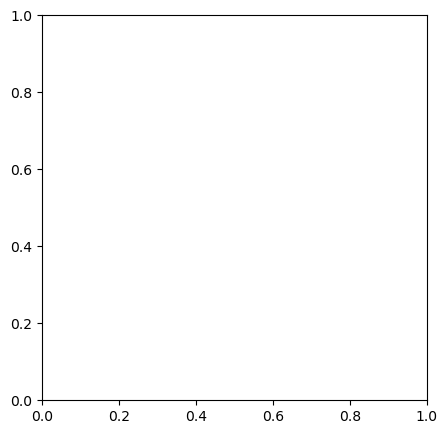

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.pie(
    [predicted_demand, max(total_generated - predicted_demand, 0)],
    labels=['Demand', 'Surplus'],
    colors=['orange', 'skyblue'],
    autopct='%1.1f%%'
)
plt.title("Energy Demand vs Supply")
plt.show()
